In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


In [2]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../../Dataset/ACB-Historical-Data_Group-9.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date','Price']]

In [3]:
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price
0,3/1/2019,11361.0
1,3/4/2019,11512.4
2,3/5/2019,11474.6
3,3/6/2019,11474.6
4,3/7/2019,11550.3
...,...,...
1303,5/27/2024,29450.0
1304,5/28/2024,29650.0
1305,5/29/2024,29250.0
1306,5/30/2024,25565.2


In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
# Select only the 'Price' column for scaling
price_data = np.array(df['Price']).reshape(-1,1) 
df = scaler.fit_transform(price_data)


In [5]:
df

array([[0.12029041],
       [0.12730068],
       [0.12555043],
       ...,
       [0.94860373],
       [0.77798666],
       [0.7356102 ]])

In [6]:
# 4. Chia train test
train_size = int(0.9 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size+1:]


In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [10]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\Windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1282 - val_loss: 0.0340
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0027 - val_loss: 0.0036
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0013 - val_loss: 0.0027
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

In [12]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [14]:
# 12. inverse transform the scaled ytest data back to its original scale.
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [15]:
# 13. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
rmse_value = np.sqrt(np.mean((y_pred - ytest)**2))
mape_value = np.mean(np.abs((ytest - y_pred) / y_pred)) * 100
mae_value = np.mean(np.abs(ytest - y_pred))

print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Error (MAE):", mae_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

Mean Absolute Percentage Error (MAPE): 1.8701018580379616
Mean Absolute Error (MAE): 518.496848958333
Root Mean Squared Error (RMSE): 870.590003480675


In [16]:
# 14.1. Dự báo 30 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.72634961 0.75181623 0.76570712 0.77265256 0.76802226 0.75181623
 0.76339197 0.76339197 0.78885859 0.76570712 0.77033741 0.77033741
 0.779598   0.79580403 0.81201006 0.80043432 0.78885859 0.78885859
 0.81201006 0.79580403 0.79580403 0.78654344 0.79811917 0.80969491
 0.88146447 0.88377962 0.89072506 0.8536827  0.87220388 0.87683418
 0.86988873 0.87683418 0.87451903 0.858313   0.86757359 0.87220388
 0.89072506 0.89072506 0.88146447 0.88146447 0.88840991 0.87220388
 0.86757359 0.84673726 0.83284638 0.83284638 0.87451903 0.85599785
 0.86062815 0.83979182 0.83747667 0.86757359 0.89072506 0.8976705
 0.86757359 0.88840991 0.89072506 0.90693109 0.91387653 0.91156138
 0.90924623 0.89072506 0.86988873 0.85136756 0.85136756 0.858313
 0.84905241 0.85136756 0.89072506 0.83747667 0.85136756 0.83284638
 0.82590094 0.83516153 0.82821609 0.84673726 0.83516153 0.83747667
 0.84442212 0.86757359 0.87220388 0.87451903 0.86988873 0.87220388
 0.87683418 0.87683418 0.87914932 0.87683418 0.902300

0 day output [[0.737905]]
1 day input [0.75181623 0.76570712 0.77265256 0.76802226 0.75181623 0.76339197
 0.76339197 0.78885859 0.76570712 0.77033741 0.77033741 0.779598
 0.79580403 0.81201006 0.80043432 0.78885859 0.78885859 0.81201006
 0.79580403 0.79580403 0.78654344 0.79811917 0.80969491 0.88146447
 0.88377962 0.89072506 0.8536827  0.87220388 0.87683418 0.86988873
 0.87683418 0.87451903 0.858313   0.86757359 0.87220388 0.89072506
 0.89072506 0.88146447 0.88146447 0.88840991 0.87220388 0.86757359
 0.84673726 0.83284638 0.83284638 0.87451903 0.85599785 0.86062815
 0.83979182 0.83747667 0.86757359 0.89072506 0.8976705  0.86757359
 0.88840991 0.89072506 0.90693109 0.91387653 0.91156138 0.90924623
 0.89072506 0.86988873 0.85136756 0.85136756 0.858313   0.84905241
 0.85136756 0.89072506 0.83747667 0.85136756 0.83284638 0.82590094
 0.83516153 0.82821609 0.84673726 0.83516153 0.83747667 0.84442212
 0.86757359 0.87220388 0.87451903 0.86988873 0.87220388 0.87683418
 0.87683418 0.87914932 0.8

In [17]:
# 14.2. Dự báo 60 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<60):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.72634961 0.75181623 0.76570712 0.77265256 0.76802226 0.75181623
 0.76339197 0.76339197 0.78885859 0.76570712 0.77033741 0.77033741
 0.779598   0.79580403 0.81201006 0.80043432 0.78885859 0.78885859
 0.81201006 0.79580403 0.79580403 0.78654344 0.79811917 0.80969491
 0.88146447 0.88377962 0.89072506 0.8536827  0.87220388 0.87683418
 0.86988873 0.87683418 0.87451903 0.858313   0.86757359 0.87220388
 0.89072506 0.89072506 0.88146447 0.88146447 0.88840991 0.87220388
 0.86757359 0.84673726 0.83284638 0.83284638 0.87451903 0.85599785
 0.86062815 0.83979182 0.83747667 0.86757359 0.89072506 0.8976705
 0.86757359 0.88840991 0.89072506 0.90693109 0.91387653 0.91156138
 0.90924623 0.89072506 0.86988873 0.85136756 0.85136756 0.858313
 0.84905241 0.85136756 0.89072506 0.83747667 0.85136756 0.83284638
 0.82590094 0.83516153 0.82821609 0.84673726 0.83516153 0.83747667
 0.84442212 0.86757359 0.87220388 0.87451903 0.86988873 0.87220388
 0.87683418 0.87683418 0.87914932 0.87683418 0.902300

In [18]:
# 14.3. Dự báo 90 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.72634961 0.75181623 0.76570712 0.77265256 0.76802226 0.75181623
 0.76339197 0.76339197 0.78885859 0.76570712 0.77033741 0.77033741
 0.779598   0.79580403 0.81201006 0.80043432 0.78885859 0.78885859
 0.81201006 0.79580403 0.79580403 0.78654344 0.79811917 0.80969491
 0.88146447 0.88377962 0.89072506 0.8536827  0.87220388 0.87683418
 0.86988873 0.87683418 0.87451903 0.858313   0.86757359 0.87220388
 0.89072506 0.89072506 0.88146447 0.88146447 0.88840991 0.87220388
 0.86757359 0.84673726 0.83284638 0.83284638 0.87451903 0.85599785
 0.86062815 0.83979182 0.83747667 0.86757359 0.89072506 0.8976705
 0.86757359 0.88840991 0.89072506 0.90693109 0.91387653 0.91156138
 0.90924623 0.89072506 0.86988873 0.85136756 0.85136756 0.858313
 0.84905241 0.85136756 0.89072506 0.83747667 0.85136756 0.83284638
 0.82590094 0.83516153 0.82821609 0.84673726 0.83516153 0.83747667
 0.84442212 0.86757359 0.87220388 0.87451903 0.86988873 0.87220388
 0.87683418 0.87683418 0.87914932 0.87683418 0.902300

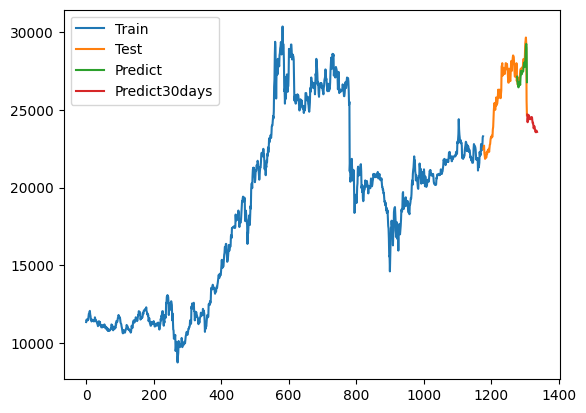

In [19]:
# 15.1.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 29, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:30]))
plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

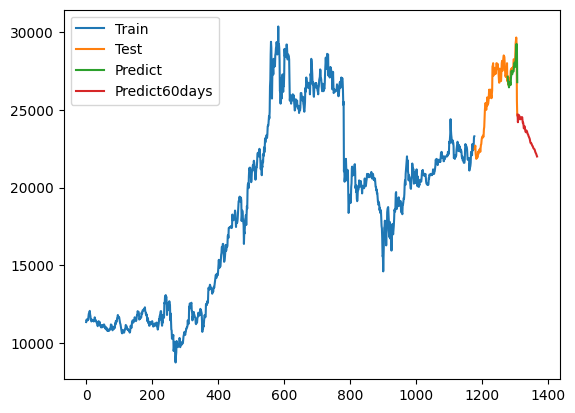

In [20]:
# 15.2.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 59, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:60]))
plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

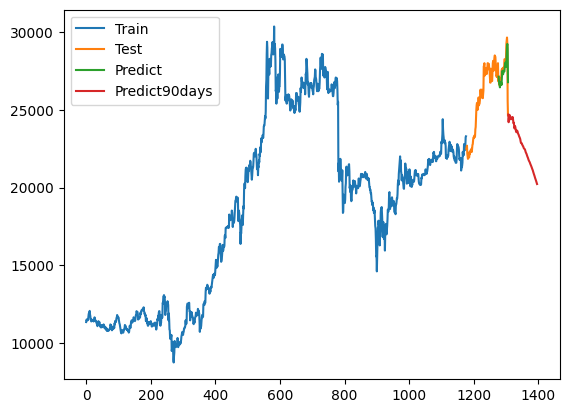

In [21]:
# 15.3.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

# Correct the test_data_index range:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 89, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:90]))
plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()